In [2]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
#PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
#act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'

act_directory = 'D:\\Analysis_Cache_M2_300'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

current_version = 0 #June 23nd, 2023
current_version = 1 # July 21st 2023

stdfont = 14
stdyfrac = 0.06


C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
animals = np.concatenate((dualanimalnames,[]))

In [4]:
animals

array(['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56',
       'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108'],
      dtype='<U32')

In [5]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\Dual\../../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite v

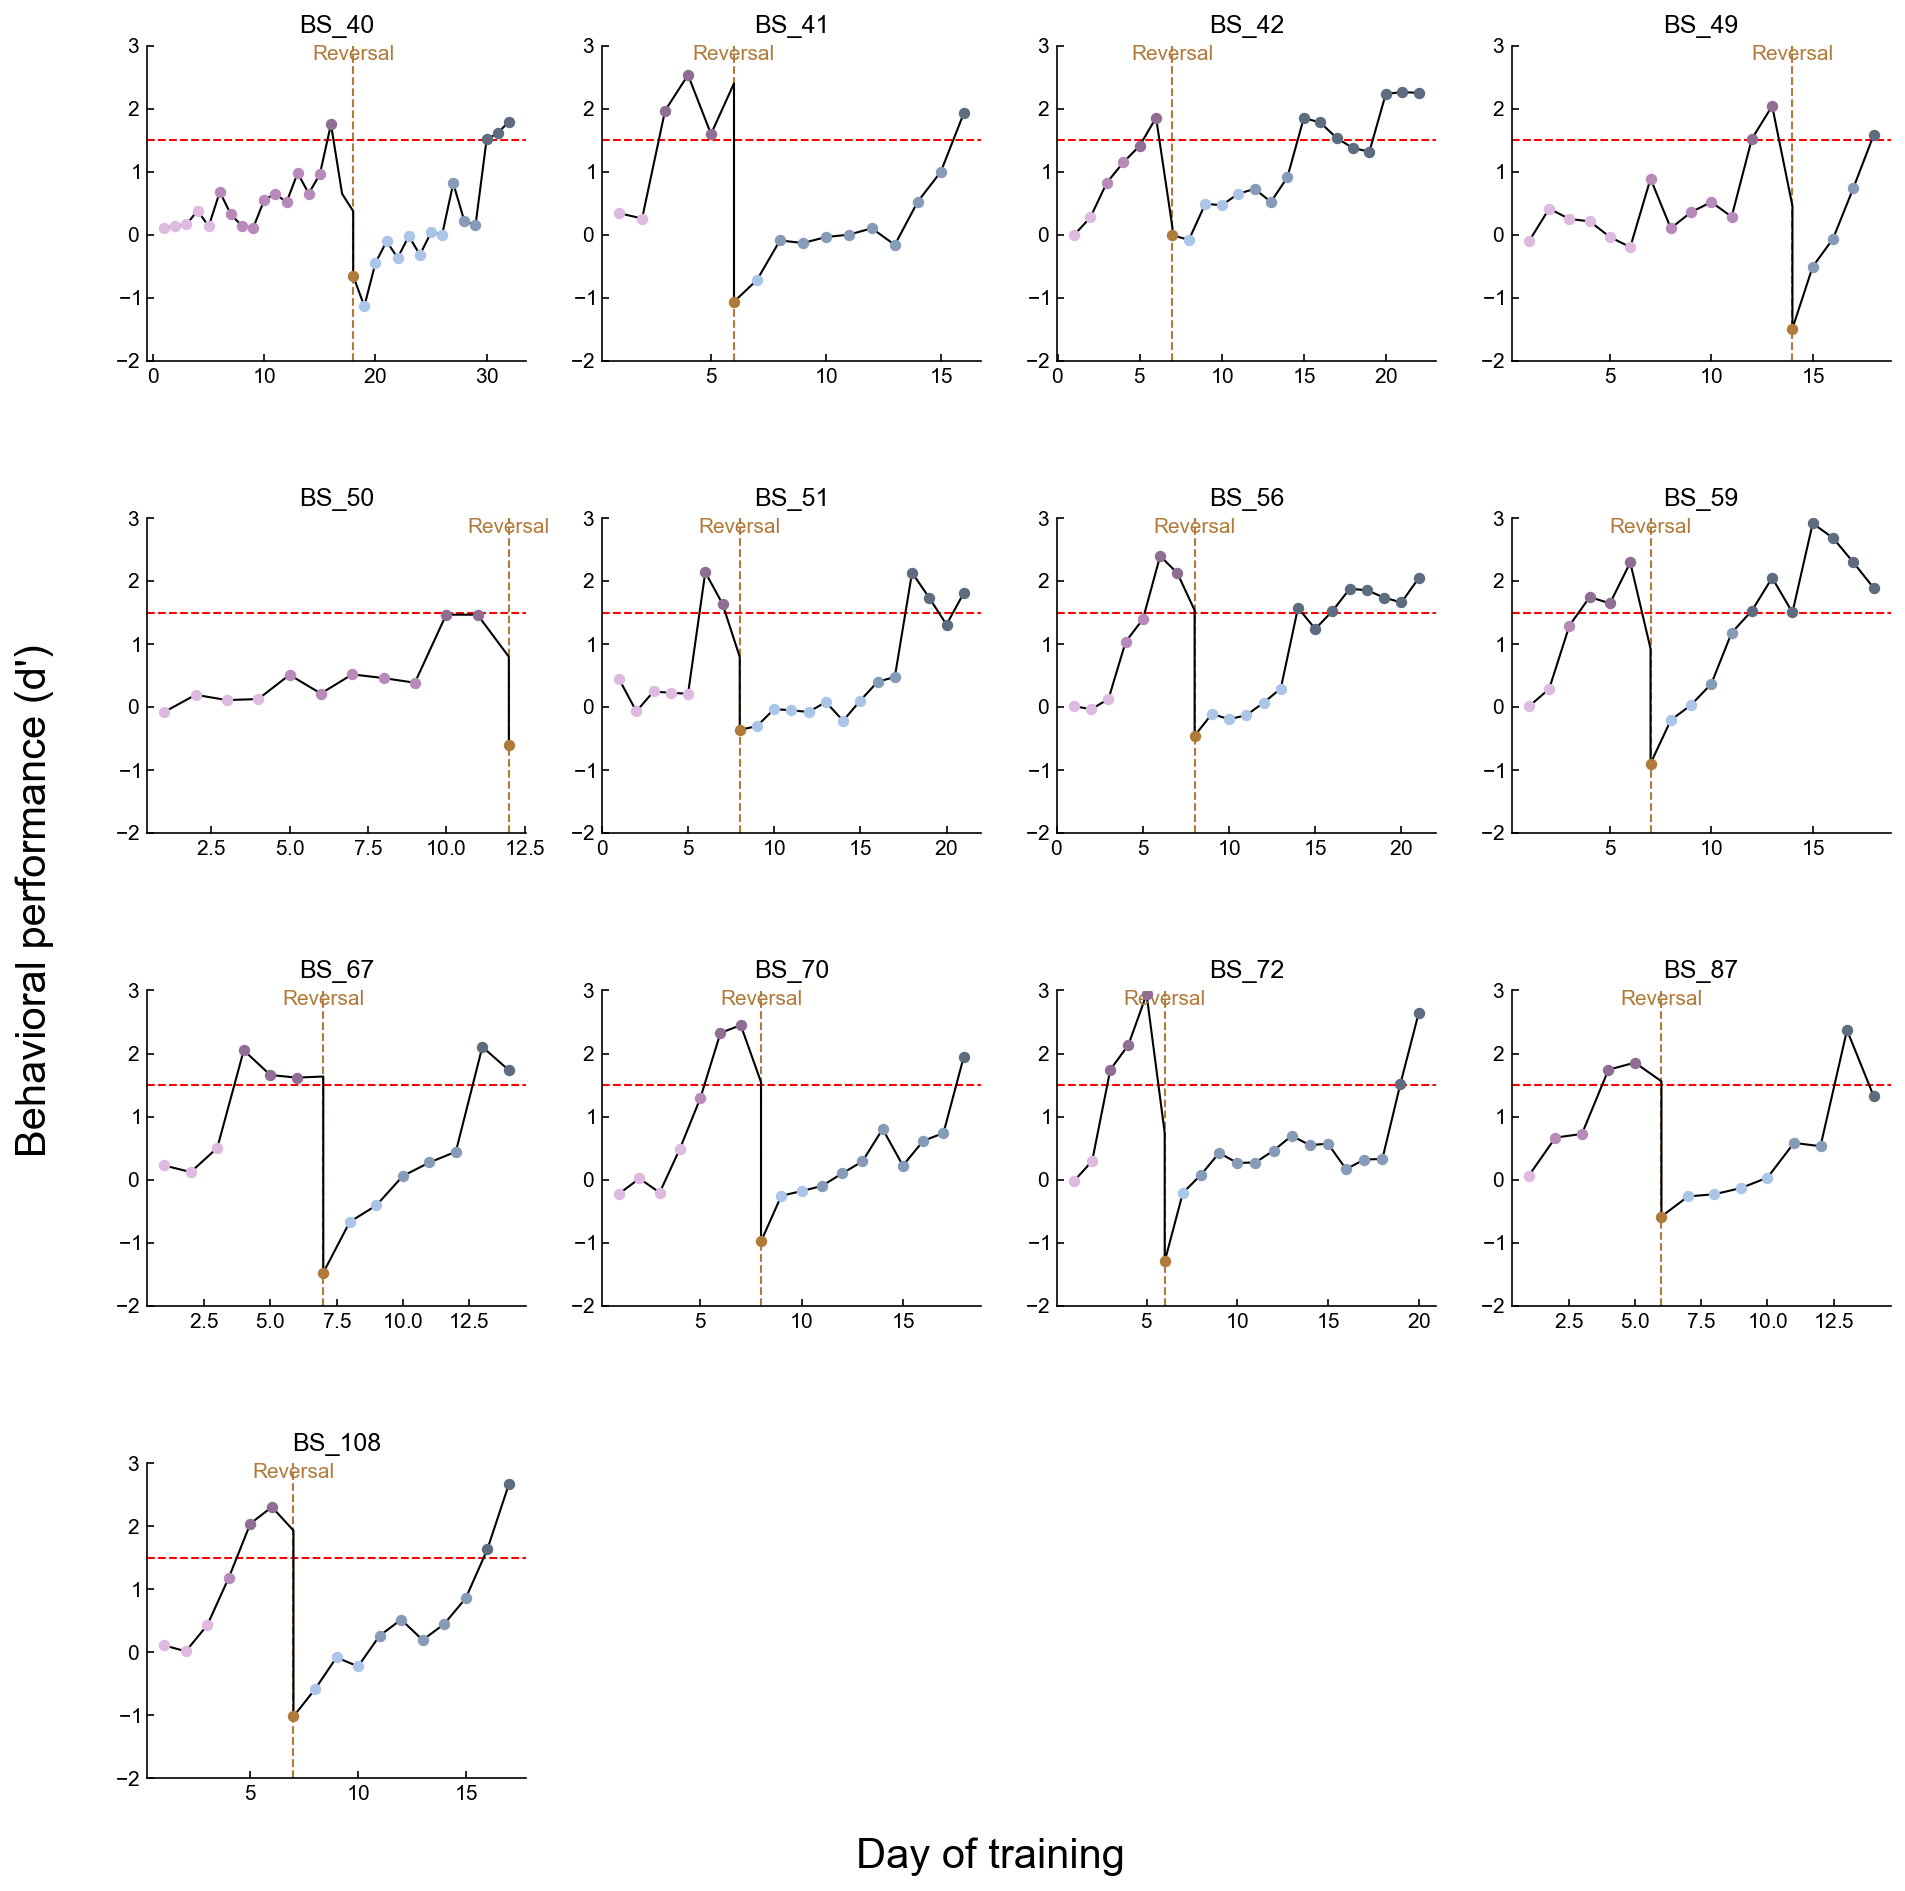

In [6]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [18]:
pre_early_dps = []
pre_early_pcs = []
pre_late_dps = []
pre_late_pcs = []
pre_expert_dps = []
pre_expert_pcs = []
post_early_dps = []
post_early_pcs = []
post_late_dps = []
post_late_pcs = []
post_expert_dps = []
post_expert_pcs = []

pre_early_min_dps = []
pre_early_min_pcs = []
pre_late_min_dps = []
pre_late_min_pcs = []
pre_expert_min_dps = []
pre_expert_min_pcs = []
post_early_min_dps = []
post_early_min_pcs = []
post_late_min_dps = []
post_late_min_pcs = []
post_expert_min_dps = []
post_expert_min_pcs = []

pre_early_max_dps = []
pre_early_max_pcs = []
pre_late_max_dps = []
pre_late_max_pcs = []
pre_expert_max_dps = []
pre_expert_max_pcs = []
post_early_max_dps = []
post_early_max_pcs = []
post_late_max_dps = []
post_late_max_pcs = []
post_expert_max_dps = []
post_expert_max_pcs = []

for animal in tqdm(animals):
    
    reversal = np.nan
    second_reversal = np.nan

    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    if hasattr(animalBehaviors[animal],'reversal') and np.isfinite(animalBehaviors[animal].reversal):
        reversal = animalBehaviors[animal].reversal
        days.append(reversal)
    if hasattr(animalBehaviors[animal],'second_reversal') and np.isfinite(animalBehaviors[animal].second_reversal):
        second_reversal = animalBehaviors[animal].second_reversal
        days.append(second_reversal)
    days = np.sort(days)
    #Needs days
    expert_days = np.concatenate(( learning_phases[animal].pre_expert_days,learning_phases[animal].post_expert_days,learning_phases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
    
   
    
    this_pre_early_dps = []
    this_pre_early_pcs = []
    this_pre_late_dps = []
    this_pre_late_pcs = []
    this_pre_expert_dps = []
    this_pre_expert_pcs = []
    this_post_early_dps = []
    this_post_early_pcs = []
    this_post_late_dps = []
    this_post_late_pcs = []
    this_post_expert_dps = []
    this_post_expert_pcs = []
    
    for day_idx,day in enumerate(days):
        if day in learning_phases[animal].pre_early_days:
            this_pre_early_dps.append(dp_list[day_idx])
            this_pre_early_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].pre_late_days:
            this_pre_late_dps.append(dp_list[day_idx])
            this_pre_late_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].pre_expert_days:
            this_pre_expert_dps.append(dp_list[day_idx])
            this_pre_expert_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_early_days:
            this_post_early_dps.append(dp_list[day_idx])
            this_post_early_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_late_days:
            this_post_late_dps.append(dp_list[day_idx])
            this_post_late_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_expert_days:
            this_post_expert_dps.append(dp_list[day_idx])
            this_post_expert_pcs.append(pc_list[day_idx])
            
    # print(f"animal {animal} has pre_late dp of {np.nanmean(this_pre_late_dps)}")
    # print(f"animal {animal} has pre_late min dp of {np.min(this_pre_late_dps)}")
    # print(f"animal {animal} has pre_late max dp of {np.max(this_pre_late_dps)}")
    #print(this_pre_late_dps)
    
    pre_early_dps.append(np.mean(this_pre_early_dps))
    pre_early_pcs.append(np.mean(this_pre_early_pcs))
    pre_late_dps.append(np.mean(this_pre_late_dps))
    pre_late_pcs.append(np.mean(this_pre_late_pcs))
    pre_expert_dps.append(np.mean(this_pre_expert_dps))
    pre_expert_pcs.append(np.mean(this_pre_expert_pcs))
    post_early_dps.append(np.mean(this_post_early_dps))
    post_early_pcs.append(np.mean(this_post_early_pcs))
    post_late_dps.append(np.mean(this_post_late_dps))
    post_late_pcs.append(np.mean(this_post_late_pcs))
    post_expert_dps.append(np.mean(this_post_expert_dps))
    post_expert_pcs.append(np.mean(this_post_expert_pcs))
    
    
    
    if np.isnan(np.mean(this_pre_early_dps)):
        pass
    else:
        this_pre_early_dps_min = np.min(this_pre_early_dps)
        pre_early_min_dps.append(this_pre_early_dps_min)
        this_pre_early_dps_max = np.max(this_pre_early_dps)
        pre_early_max_dps.append(this_pre_early_dps_max)
        
    if np.isnan(np.mean(this_pre_late_dps)):
        pass
    else:
        this_pre_late_dps_min = np.min(this_pre_late_dps)
        pre_late_min_dps.append(this_pre_late_dps_min)
        this_pre_late_dps_max = np.max(this_pre_late_dps)
        pre_late_max_dps.append(this_pre_late_dps_max)
        
    if np.isnan(np.mean(this_pre_expert_dps)):
        pass
    else:
        this_pre_expert_dps_min = np.min(this_pre_expert_dps)
        pre_expert_min_dps.append(this_pre_expert_dps_min)
        this_pre_expert_dps_max = np.max(this_pre_expert_dps)
        pre_expert_max_dps.append(this_pre_expert_dps_max)
      
    
    if np.isnan(np.mean(this_post_early_dps)):
        pass
    else:
        this_post_early_dps_min = np.min(this_post_early_dps)
        post_early_min_dps.append(this_post_early_dps_min)
        this_post_early_dps_max = np.max(this_post_early_dps)
        post_early_max_dps.append(this_post_early_dps_max)
        
    if np.isnan(np.mean(this_post_late_dps)):
        pass
    else:
        this_post_late_dps_min = np.min(this_post_late_dps)
        post_late_min_dps.append(this_post_late_dps_min)
        this_post_late_dps_max = np.max(this_post_late_dps)
        post_late_max_dps.append(this_post_late_dps_max)
        
    if np.isnan(np.mean(this_post_expert_dps)):
        pass
    else:
        this_post_expert_dps_min = np.min(this_post_expert_dps)
        post_expert_min_dps.append(this_post_expert_dps_min)
        this_post_expert_dps_max = np.max(this_post_expert_dps)
        post_expert_max_dps.append(this_post_expert_dps_max)
        
    print(animal)
    print(this_post_expert_dps)
#     if animal == 'BS_41':
#         print(expert_days)
#         print(this_post_expert_dps)
        
#     if animal == 'BS_51':
#         print(expert_days)
#         print(this_post_expert_dps)
#     try:
#         pre_early_min_dps.append(np.min(this_pre_early_dps))
#         pre_early_min_pcs.append(np.min(this_pre_early_pcs))
#         pre_late_min_dps.append(np.min(this_pre_late_dps))
#         pre_late_min_pcs.append(np.min(this_pre_late_pcs))
#         pre_expert_min_dps.append(np.min(this_pre_expert_dps))
#         pre_expert_min_pcs.append(np.min(this_pre_expert_pcs))
#         post_early_min_dps.append(np.min(this_post_early_dps))
#         post_early_min_pcs.append(np.min(this_post_early_pcs))
#         post_late_min_dps.append(np.min(this_post_late_dps))
#         post_late_min_pcs.append(np.min(this_post_late_pcs))
#         post_expert_min_dps.append(np.min(this_post_expert_dps))
#         post_expert_min_pcs.append(np.min(this_post_expert_pcs))
    
#         pre_early_max_dps.append(np.max(this_pre_early_dps))
#         pre_early_max_pcs.append(np.max(this_pre_early_pcs))
#         pre_late_max_dps.append(np.max(this_pre_late_dps))
#         pre_late_max_pcs.append(np.max(this_pre_late_pcs))
#         pre_expert_max_dps.append(np.max(this_pre_expert_dps))
#         pre_expert_max_pcs.append(np.max(this_pre_expert_pcs))
#         post_early_max_dps.append(np.max(this_post_early_dps))
#         post_early_max_pcs.append(np.max(this_post_early_pcs))
#         post_late_max_dps.append(np.max(this_post_late_dps))
#         post_late_max_pcs.append(np.max(this_post_late_pcs))
#         post_expert_max_dps.append(np.max(this_post_expert_dps))
#         post_expert_max_pcs.append(np.max(this_post_expert_pcs))
        
#     except Exception as e:
#         #print(f"animal {animal} exception {e}")
#         pass

 31%|███       | 4/13 [00:00<00:00, 37.74it/s]

BS_40
[1.5100097610843206, 1.6066230711417375, 1.7931402187188945]
BS_41
[1.9229444503282003]
BS_42
[1.847988552553565, 1.7793766236953463, 1.5324404387928947, 1.3705404686371159, 1.3154589112775408, 2.231605835260925, 2.259977300998866, 2.248671930020573]
BS_49
[1.5721088955828284]
BS_50
[]
BS_51
[2.1331431214346175, 1.7321992757232594, 1.3080859343749551, 1.8081935048078654]
BS_56
[1.575104556644539, 1.2385778408136465, 1.524055187168912, 1.8768878840587229, 1.853308740524403, 1.7362715249249079, 1.6588609798575582, 2.0435735735496667]


100%|██████████| 13/13 [00:00<00:00, 30.53it/s]

BS_59
[1.528516813128906, 2.051026314620989, 1.501085946044025, 2.9148852681514192, 2.6836744715654515, 2.2977272186317887, 1.8922878731011656]
BS_67
[2.105463373066448, 1.7346922207139857]
BS_70
[1.9457918755241324]
BS_72
[1.5237170453601, 2.6373063302622146]
BS_87
[2.371705981878082, 1.328952480899487]
BS_108
[1.6278511220764345, 2.6614628334995087]


In [19]:
print(len(pre_early_dps))
print(len(pre_late_dps))
print(len(pre_expert_dps))
print(len(post_early_dps))
print(len(post_late_dps))
print(len(post_expert_dps))

13
13
13
13
13
13


In [20]:
post_expert_dps

[1.6365910169816509,
 1.9229444503282003,
 1.8232575076546031,
 1.5721088955828284,
 nan,
 1.7454054590851742,
 1.6883300359427946,
 2.1241719864633923,
 1.9200777968902167,
 1.9457918755241324,
 2.0805116878111574,
 1.8503292313887845,
 2.144656977787972]

# skip

In [11]:
sessions = os.listdir(act_directory)

In [26]:
EnumACSession = []
EnumACClust = []

sessions = os.listdir(act_directory)

numAC = 0

for session in tqdm(sessions):

    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal !='BS_41':
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    else:
        pass

        
print('AC       : ' + str(numAC))

100%|██████████| 550/550 [00:07<00:00, 76.23it/s] 

AC       : 157


In [29]:
for session in EnumACSession: #17, 18
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.condition=='postreversal expert':
        print(sessionfile.meta.day_of_training)

19
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17


In [30]:
sessionfile.meta

namespace(directory='C:\\Users\\insan\\Desktop\\BS_41 10\\AC\\',
          region='AC',
          animal='BS_41',
          probe=7375,
          date='8/18/2021',
          depth=1105,
          task='reversal',
          day_of_training=15,
          day_of_recording=9,
          day_of_reversal=9,
          length_in_samples=111155372.0,
          files=['August 18 2021 Dual BS_41_10001',
                 'August 18 2021 Dual BS_41_10002',
                 'August 18 2021 Dual BS_41_10003',
                 'August 18 2021 Dual BS_41_10004'],
          behavior='naive',
          condition='postreversal naive',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=3705.1790666666666,
          length_in_minutes=61.752984444444444,
          length_in_trials=600)

In [23]:
EnumACSession = []
EnumACClust = []

sessions = os.listdir(act_directory)

numAC = 0

for session in tqdm(sessions):

    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal !='BS_51':
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    else:
        pass

        
print('AC       : ' + str(numAC))

100%|██████████| 550/550 [00:07<00:00, 71.41it/s] 

AC       : 4


In [24]:
for session in EnumACSession: #20
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.condition=='postreversal expert':
        print(sessionfile.meta.day_of_training)

21
21
21
21


In [25]:
sessionfile.meta

namespace(directory='D:\\BS_51\\BS_51 2\\AC\\',
          region='AC',
          animal='BS_51',
          probe=6927,
          date='10/14/2021',
          depth=1300,
          task='reversal',
          day_of_training=21,
          day_of_recording=2,
          day_of_reversal=11,
          length_in_samples=41035394.0,
          files=['October 14 2021 Dual BS_51_2001',
                 'October 14 2021 Dual BS_51_2002'],
          behavior='expert',
          condition='postreversal expert',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=1367.8464666666666,
          length_in_minutes=22.79744111111111,
          length_in_trials=376)

In [31]:
EnumACSession = []
EnumACClust = []

sessions = os.listdir(act_directory)

numAC = 0

for session in tqdm(sessions):

    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal !='BS_87':
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    else:
        pass

        
print('AC       : ' + str(numAC))

100%|██████████| 550/550 [00:06<00:00, 79.48it/s] 

AC       : 144


In [33]:
for session in EnumACSession: #20
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.condition=='postreversal expert':
        print(sessionfile.meta.animal)
        print(sessionfile.meta.day_of_training)

BS_87
13
BS_87
14
BS_87
14
BS_87
14
BS_87
14
BS_87
14
BS_87
15
BS_87
15
BS_87
15
BS_87
15
BS_87
10
BS_87
10
BS_87
10
BS_87
11
BS_87
11
BS_87
11
BS_87
11
BS_87
11
BS_87
11
BS_87
11
BS_87
11
BS_87
11
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12
BS_87
12


In [13]:
pre_early_last_dps = []
pre_early_last_pcs = []
pre_late_last_dps = []
pre_late_last_pcs = []
pre_expert_last_dps = []
pre_expert_last_pcs = []
post_early_last_dps = []
post_early_last_pcs = []
post_late_last_dps = []
post_late_last_pcs = []
post_expert_last_dps = []
post_expert_last_pcs = []



for animal in tqdm(animals):
    
    reversal = np.nan
    second_reversal = np.nan

    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    if hasattr(animalBehaviors[animal],'reversal') and np.isfinite(animalBehaviors[animal].reversal):
        reversal = animalBehaviors[animal].reversal
        days.append(reversal)
    if hasattr(animalBehaviors[animal],'second_reversal') and np.isfinite(animalBehaviors[animal].second_reversal):
        second_reversal = animalBehaviors[animal].second_reversal
        days.append(second_reversal)
    days = np.sort(days)
    #Needs days
    expert_days = np.concatenate(( learning_phases[animal].pre_expert_days,learning_phases[animal].post_expert_days,learning_phases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
    
    this_pre_early_dps = []
    this_pre_early_pcs = []
    this_pre_late_dps = []
    this_pre_late_pcs = []
    this_pre_expert_dps = []
    this_pre_expert_pcs = []
    this_post_early_dps = []
    this_post_early_pcs = []
    this_post_late_dps = []
    this_post_late_pcs = []
    this_post_expert_dps = []
    this_post_expert_pcs = []
    
    for day_idx,day in enumerate(days):
        if day in learning_phases[animal].pre_early_days:
            this_pre_early_dps.append(dp_list[day_idx])
            this_pre_early_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].pre_late_days:
            this_pre_late_dps.append(dp_list[day_idx])
            this_pre_late_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].pre_expert_days:
            this_pre_expert_dps.append(dp_list[day_idx])
            this_pre_expert_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_early_days:
            this_post_early_dps.append(dp_list[day_idx])
            this_post_early_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_late_days:
            this_post_late_dps.append(dp_list[day_idx])
            this_post_late_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_expert_days:
            this_post_expert_dps.append(dp_list[day_idx])
            this_post_expert_pcs.append(pc_list[day_idx])
            
    # print(f"animal {animal} has pre_late dp of {np.nanmean(this_pre_late_dps)}")
    # print(f"animal {animal} has pre_late min dp of {np.min(this_pre_late_dps)}")
    # print(f"animal {animal} has pre_late max dp of {np.max(this_pre_late_dps)}")
    # print(this_pre_late_dps)
    
    if np.isnan(np.mean(this_pre_early_dps)):
        pass
    else:
        pre_early_last_dps.append(this_pre_early_dps[-1])
        
    if np.isnan(np.mean(this_pre_late_dps)):
        pass
    else:
        pre_late_last_dps.append(this_pre_late_dps[-1])
        
    if np.isnan(np.mean(this_pre_expert_dps)):
        pass
    else:
        pre_expert_last_dps.append(this_pre_expert_dps[-1])
    
    if np.isnan(np.mean(this_post_early_dps)):
        pass
    else:
        post_early_last_dps.append(this_post_early_dps[-1])
        
    if np.isnan(np.mean(this_post_late_dps)):
        pass
    else:
        post_late_last_dps.append(this_post_late_dps[-1])
        
    if np.isnan(np.mean(this_post_expert_dps)):
        pass
    else:
        post_expert_last_dps.append(this_post_expert_dps[-1])
        
    if animal == 'BS_87':
        print(this_post_expert_dps)

100%|██████████| 15/15 [00:00<00:00, 26.91it/s]

[2.371705981878082, 1.328952480899487]


In [12]:
pre_early_last_dps

[0.13066799499474524,
 0.2535617622697345,
 0.2733067248473744,
 -0.20045666054678501,
 0.1261876825480146,
 0.2116256484487965,
 0.12648658038644361,
 0.28796781478175587,
 0.5009665918390012,
 0.49016044459348773,
 0.29368628205223546,
 0.06326054917403019,
 0.42674175836952055,
 0.28065596287853234,
 0.1517062911163669]

In [13]:
pre_late_last_dps

[0.9574391926440188,
 1.143057083081818,
 0.28147674763965447,
 0.3851433063895091,
 1.3948340983315297,
 1.2933517760248756,
 1.286041054075907,
 0.7232491452796587,
 1.181953692631149,
 0.8910589144638188,
 0.5291550021740763]

In [11]:
print(np.sum(np.isfinite(pre_early_dps)))
print(np.sum(np.isfinite(pre_late_dps)))
print(np.sum(np.isfinite(pre_expert_dps)))
print(np.sum(np.isfinite(post_early_dps)))
print(np.sum(np.isfinite(post_late_dps)))
print(np.sum(np.isfinite(post_expert_dps)))

15
11
15
13
13
14


In [10]:
print(f"pre early: {np.nanmean(pre_early_dps)} +/- {np.std(ilep.rmnan(pre_early_dps))}")
print(f"pre late: {np.nanmean(pre_late_dps)} +/- {np.std(ilep.rmnan(pre_late_dps))}")
print(f"pre expert: {np.nanmean(pre_expert_dps)} +/- {np.std(ilep.rmnan(pre_expert_dps))}")
print(f"post early: {np.nanmean(post_early_dps)} +/- {np.std(ilep.rmnan(post_early_dps))}")
print(f"post late: {np.nanmean(post_late_dps)} +/- {np.std(ilep.rmnan(post_late_dps))}")
print(f"post expert: {np.nanmean(post_expert_dps)} +/- {np.std(ilep.rmnan(post_expert_dps))}")

pre early: 0.1303006366835917 +/- 0.08624332451809763
pre late: 0.8613900754532011 +/- 0.3344997042217228
pre expert: 1.8819342995554351 +/- 0.2765198847274632
post early: -0.1711183566376537 +/- 0.26158139935273694
post late: 0.44350511974041085 +/- 0.20500827580385103
post expert: 1.8936178343462058 +/- 0.2043707366682185


In [20]:
p1 = ttest_ind(ilep.rmnan(pre_early_dps),ilep.rmnan(pre_late_dps)).pvalue
p2 = ttest_ind(ilep.rmnan(pre_late_dps),ilep.rmnan(pre_expert_dps)).pvalue
p3 = ttest_ind(ilep.rmnan(post_early_dps),ilep.rmnan(post_late_dps)).pvalue
p4 = ttest_ind(ilep.rmnan(post_late_dps),ilep.rmnan(post_expert_dps)).pvalue
pvals = [p1,p2,p3,p4]
# print(pvals)
_,pvals_corr = pg.multicomp(pvals,method='fdr_bh')
print(pvals_corr)

[6.75440015e-08 4.36160182e-08 1.26547039e-06 4.72318274e-15]


In [9]:
#pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps

In [9]:
Data = SimpleNamespace()
Data.preearly =pre_early_dps
Data.prelate = pre_late_dps
Data.preexpert = pre_expert_dps
Data.postearly = post_early_dps
Data.postlate = post_late_dps
Data.postexpert = post_expert_dps
ilep.nonparametricIndependentStatsCompareToPrevious(Data)

            Source         SS    DF         MS           F         p-unc  \
0            phase  25.937642   3.0   8.645881  133.392185  2.693110e-34   
1          context  23.881271   1.0  23.881271  368.450020  8.387271e-35   
2  phase * context   2.750346   3.0   0.916782   14.144489  1.015466e-07   
3         Residual   6.287103  97.0   0.064815         NaN           NaN   

        np2  
0  0.804898  
1  0.791600  
2  0.304328  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000011  0.000028 -6.610813
8     post-late  baseline  experimental  0.000041  0.000041 -2.433426
9    pre-expert  baseline  experimental  0.000021  0.000028 -3.139927
10     pre-late  baseline  experimental  0.000021  0.000028 -2.993684
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 13 non-nan elements
key postlate has 13 non-nan elements
key postexpe

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,613.5,two-sided,3.120412e-06,6.240825e-06,fdr_bh,1.700938
1,phase,-,post-expert,pre-expert,False,False,292.0,two-sided,2.979531e-01,2.979531e-01,fdr_bh,-0.363657
2,phase,-,post-expert,pre-late,False,False,565.0,two-sided,1.455183e-04,2.182774e-04,fdr_bh,1.187903
3,phase,-,post-late,pre-expert,False,False,26.0,two-sided,1.192319e-08,7.153915e-08,fdr_bh,-2.549991
4,phase,-,post-late,pre-late,False,False,219.0,two-sided,3.010615e-02,3.612738e-02,fdr_bh,-0.719495
5,phase,-,pre-expert,pre-late,False,False,615.5,two-sided,3.965210e-07,1.189563e-06,fdr_bh,1.899967
6,context,-,baseline,experimental,False,False,312.0,two-sided,8.530787e-12,NaN,NaN,-1.758903
7,phase * context,post-expert,baseline,experimental,False,False,0.0,two-sided,1.125106e-05,2.777443e-05,fdr_bh,-6.610813
8,phase * context,post-late,baseline,experimental,False,False,4.0,two-sided,4.085966e-05,4.085966e-05,fdr_bh,-2.433426
9,phase * context,pre-expert,baseline,experimental,False,False,0.0,two-sided,2.083082e-05,2.777443e-05,fdr_bh,-3.139927


In [9]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [10]:
2.777443e-05 	 <0.0001

True

In [83]:
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    data[idx]=Y

In [98]:
data[2]

array([1.75068607, 2.0307985 , 1.63190295, 1.77933283, 1.46521765,
       1.88764963, 2.2604975 , 1.89490217, 1.77559337, 2.38822495,
       2.27297867, 1.79875341, 2.1704552 , 1.54292544, 1.57909616])

In [100]:
datamin[2]

[1.75068607125217,
 1.4083299957411488,
 1.5188583959177937,
 1.4647446343707897,
 2.1232101827174468,
 1.6452461624782282,
 2.3268289119347836,
 1.7420602740742228,
 2.038787934535881,
 1.4369018399571327,
 1.151204213958647]

# skip

meta NOT subset; don't know how to subset; dropped


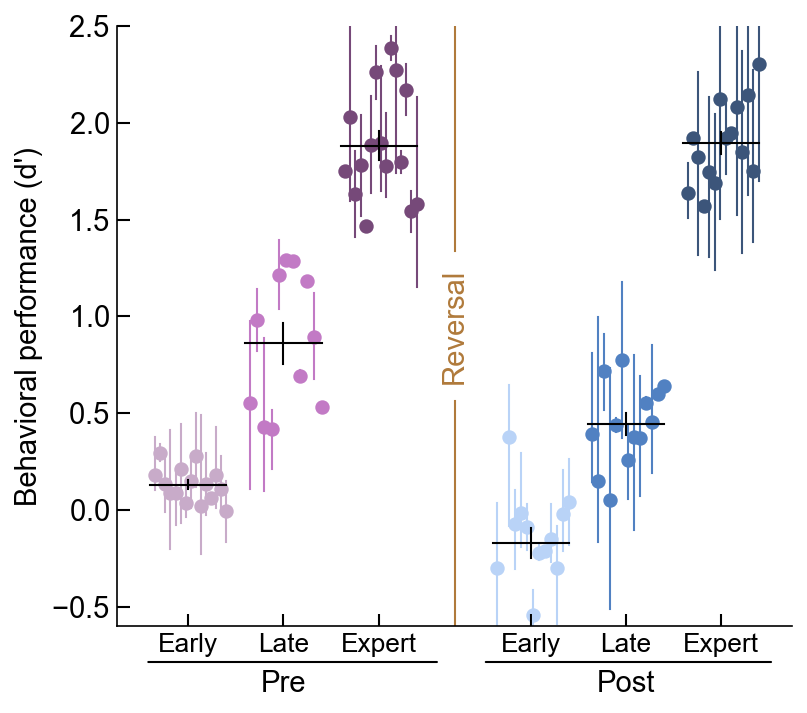

In [22]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4.5, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.3
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
datamin = [pre_early_min_dps,pre_late_min_dps,pre_expert_min_dps,post_early_min_dps,post_late_min_dps,post_expert_min_dps]
datamax = [pre_early_max_dps,pre_late_max_dps,pre_expert_max_dps,post_early_max_dps,post_late_max_dps,post_expert_max_dps]

labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
#width = 0.3
width = 0.1

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    data[idx]=Y
      
for idx,column in enumerate(data):
    Y = (column)
    rand_set = 0.5
    #X = np.random.uniform(-width/rand_set,width/rand_set,size=len(Y)) + idx
    X = np.linspace(-0.35,0.4,num=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    perform_min  = datamin[idx]
    perform_max  = datamax[idx]
    perform_range = ([perform_min,perform_max])
    
    if idx<3:
        X_position = X-switch_offset
        ax.scatter(X_position,Y,s=sz,color=PHASE_COLORS[idx])
        ax.plot([X_position]*2,perform_range,lw=1,color=PHASE_COLORS[idx])
        
        ax.plot([idx-switch_offset-width*4,idx-switch_offset+width*4],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
        

        
    else:
        X_position = X+switch_offset
        ax.scatter(X_position,Y,s=sz,color=PHASE_COLORS[idx])
        ax.plot([X_position]*2,perform_range,lw=1,color=PHASE_COLORS[idx])
        
        ax.plot([idx+switch_offset-width*4,idx+switch_offset+width*4],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior_March.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


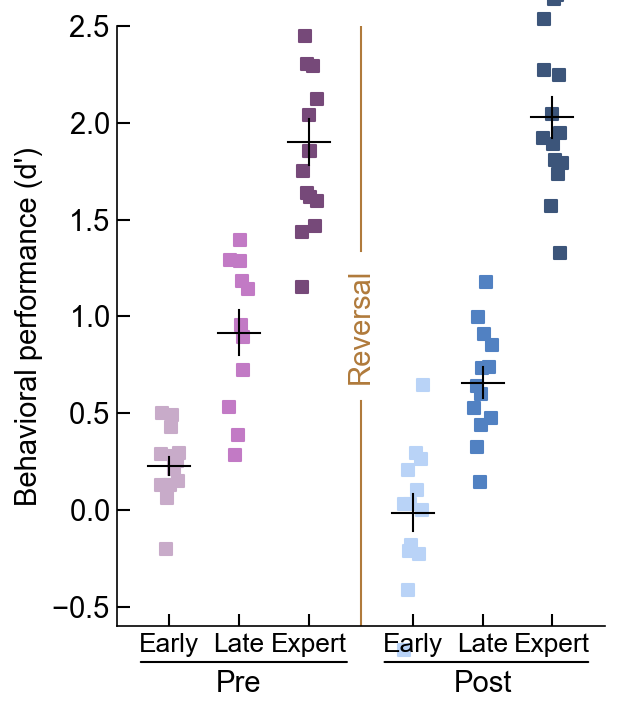

In [23]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_last_dps,pre_late_last_dps,pre_expert_last_dps,post_early_last_dps,post_late_last_dps,post_expert_last_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s',clip_on = False)
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s',clip_on = False)
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\last day of performance.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [8]:
Data = SimpleNamespace()
Data.preearly =pre_early_last_dps
Data.prelate = pre_late_last_dps
Data.preexpert = pre_expert_last_dps
Data.postearly = post_early_last_dps
Data.postlate = post_late_last_dps
Data.postexpert = post_expert_last_dps
ilep.nonparametricIndependentStatsCompareToPrevious(Data)

NameError: name 'pre_early_last_dps' is not defined

In [25]:
4.500423e-05 < 0.0001

True

In [26]:
1.477198e-04 < 0.0001

False

In [27]:
1.032285e-04 < 0.0001

False

In [28]:
1.477198e-04<0.0001

False

# V1

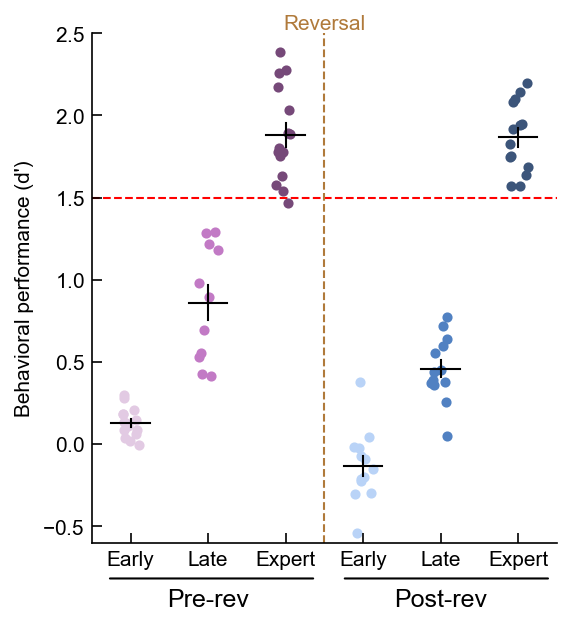

In [86]:
fig, ax = plt.subplots(figsize=(4,4.5))
data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

width = 0.25
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    ax.scatter(X,Y,s=15,color=PHASE_COLORS[idx])
    
    mean = np.mean(Y)
    SEM = sem(Y)
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylim([-0.6,2.5])
ax.set_ylabel('Behavioral performance (d\')')

#ax.text(5,ax.get_ylim()[0],f"N = {len(animals)}\n",horizontalalignment='center',verticalalignment='bottom')
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,linestyle='--',color=SWITCH_COLOR,lw=1,zorder=-9)
ax.axhline(1.5,linestyle='--',color='red',lw=1,zorder=-10)

ax.tick_params(length=5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.8749628968456478, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, -0.8749628968456478, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.535, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Performance over phases dprime V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

# V2

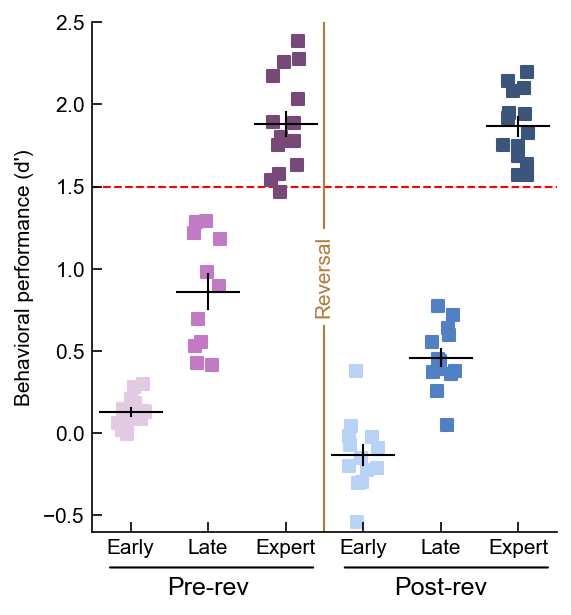

In [6]:
fig, ax = plt.subplots(figsize=(4,4.5))
data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.4

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    ax.scatter(X,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
    
    mean = np.mean(Y)
    SEM = sem(Y)
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylim([-0.6,2.5])
ax.set_ylabel('Behavioral performance (d\')')

rev = 2.5
size = 0.3
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

ax.axhline(1.5,linestyle='--',color='red',lw=1,zorder=-10)

ax.tick_params(length=5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.8749628968456478, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, -0.8749628968456478, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.535, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Performance over phases dprime V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

# V3

meta NOT subset; don't know how to subset; dropped


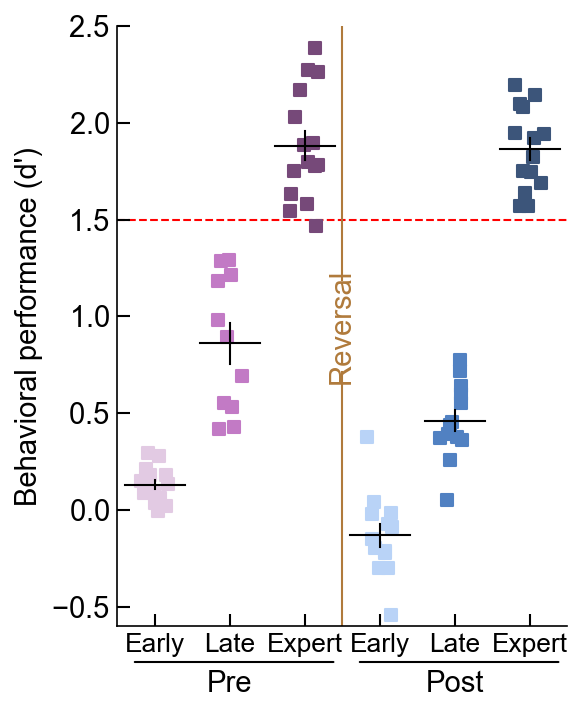

In [13]:
stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.4

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    ax.scatter(X,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
    
    mean = np.mean(Y)
    SEM = sem(Y)
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax.axhline(1.5,linestyle='--',color='red',lw=1,zorder=-10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# V4

In [7]:
stdfont = 14
stdyfrac = 0.06

meta NOT subset; don't know how to subset; dropped


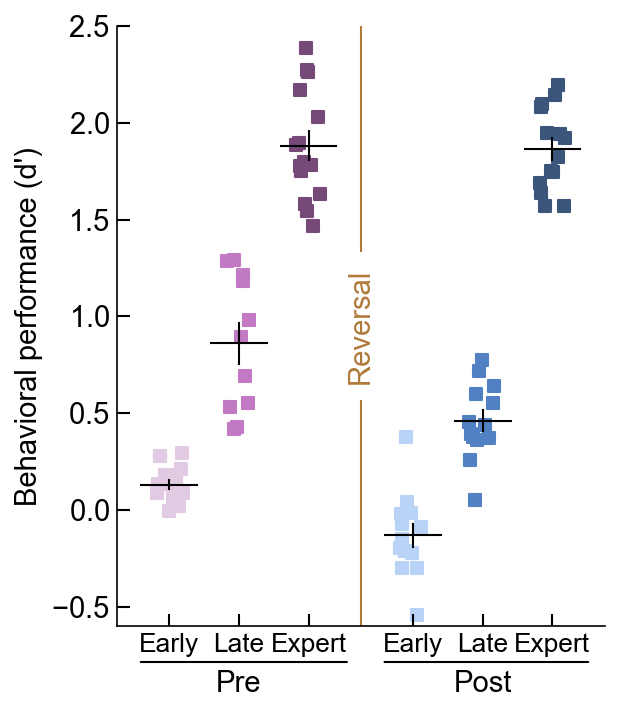

In [19]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.4

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# V5

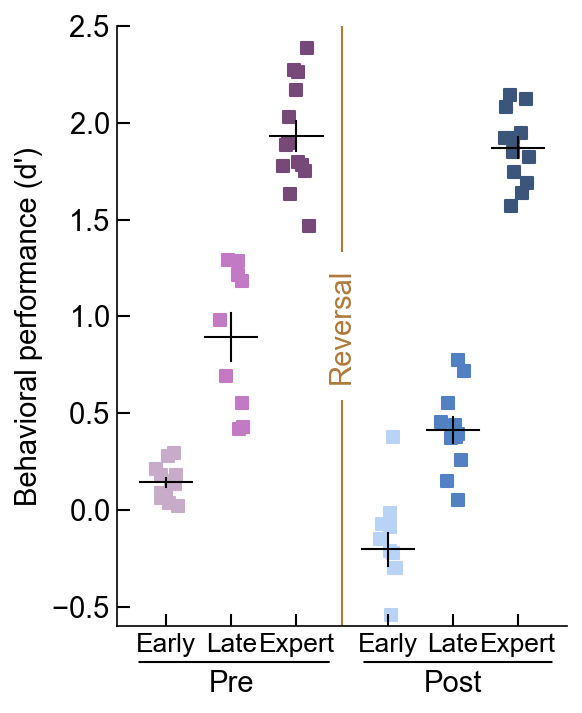

In [9]:

stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.4

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# V6

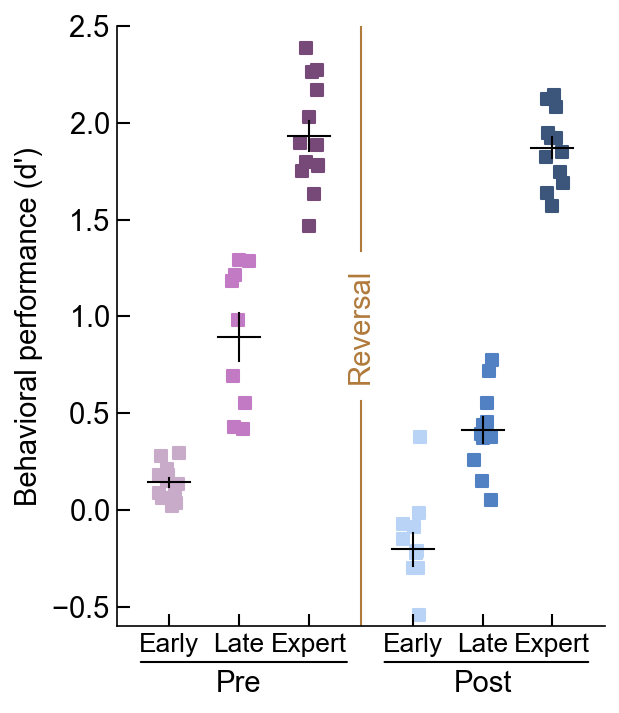

In [26]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [21]:
len(post_expert_dps)

13

In [23]:
np.nanstd(post_expert_dps)

0.18021099293459886

In [25]:
np.nanmean(post_expert_dps)

1.8711814101200754

0.14260669069831483
0.8944933843502084
1.9313071452585526
-0.20422940461470607
0.4117943086580987
1.8711814101200754


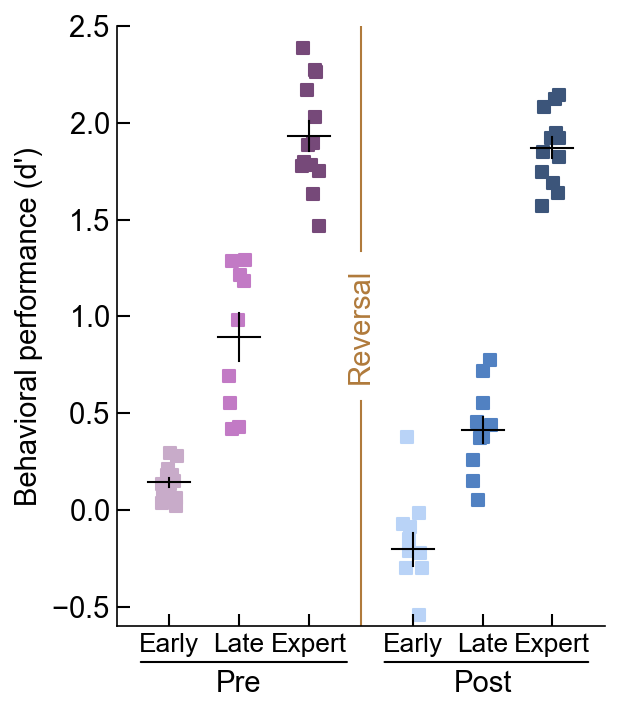

In [11]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    print(mean)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

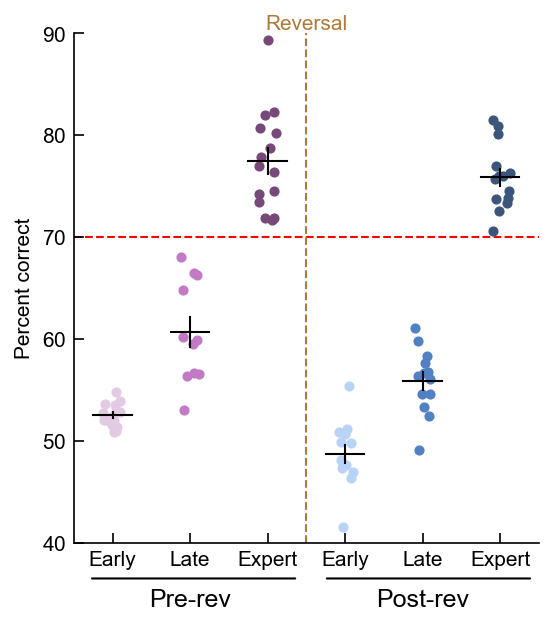

In [85]:
fig, ax = plt.subplots(figsize=(4,4.5))
data = [pre_early_pcs,pre_late_pcs,pre_expert_pcs,post_early_pcs,post_late_pcs,post_expert_pcs]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

width = 0.25
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)*100
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    ax.scatter(X,Y,s=15,color=PHASE_COLORS[idx])
    
    mean = np.mean(Y)
    SEM = sem(Y)
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylim([40,90])
ax.set_ylabel('Percent correct')

#ax.text(5,ax.get_ylim()[0],f"N = {len(animals)}\n",horizontalalignment='center',verticalalignment='bottom')
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,linestyle='--',color=SWITCH_COLOR,lw=1,zorder=-9)
ax.axhline(70,linestyle='--',color='red',lw=1,zorder=-10)

ax.tick_params(length=5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 35.56511456700568, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 35.56511456700568, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.535, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Performance over phases pc V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [27]:
-0.8749628968456478 + 0.6

-0.2749628968456478

In [29]:
-0.2749628968456478 / (2.5+0.6) * (90-40) + 40

35.56511456700568

# Slope

In [12]:
#Note that you must pass in the dps from the phase in question and also the first day of the next session
def GetSlope(dps):
    if len(dps) <= 1:
        return np.nan
    elif len(dps) == 2:
        return dps[1] - dps[0]
    elif len(dps) > 2:
        res = linregress(range(len(dps)),dps)
        return res.slope
    
def add_day(a,b):
    if len(b) <= 0:
        return a
    if len(a) > 0:
        return np.concatenate((a,[np.min(b)]))
    else:
        return [np.min(b)]

In [13]:
dpslope_pre_early = []
dpslope_pre_late = []
dpslope_pre_expert = []
dpslope_post_early = []
dpslope_post_late = []
dpslope_post_expert = []

for animal in animals:
    
    ### Get days
    pre_early_days = learning_phases[animal].pre_early_days
    pre_late_days = learning_phases[animal].pre_late_days
    pre_expert_days = learning_phases[animal].pre_expert_days
    
    post_early_days = learning_phases[animal].post_early_days
    post_late_days = learning_phases[animal].post_late_days
    post_expert_days = learning_phases[animal].post_expert_days
    
    ### Add first day of next phase
    pre_early_days = add_day(pre_early_days,pre_late_days)
    pre_late_days = add_day(pre_late_days,pre_expert_days)
    post_early_days = add_day(post_early_days,post_late_days)
    post_late_days = add_day(post_late_days,post_expert_days)
    
#     print(pre_early_days)
#     print(pre_late_days)
#     print(pre_expert_days)
#     print(post_early_days)
#     print(post_late_days)
#     print(post_expert_days)
#     print()""

    ### Get DPs
    expert_days = np.concatenate((pre_expert_days,post_expert_days))
    pre_early_dps,_ = ilep.getPCDPfromBehavior(animalBehaviors,animal,pre_early_days,expert_days)
    pre_late_dps,_ = ilep.getPCDPfromBehavior(animalBehaviors,animal,pre_late_days,expert_days)
    pre_expert_dps,_ = ilep.getPCDPfromBehavior(animalBehaviors,animal,pre_expert_days,expert_days)
    
    post_early_dps,_ = ilep.getPCDPfromBehavior(animalBehaviors,animal,post_early_days,expert_days)
    post_late_dps,_ = ilep.getPCDPfromBehavior(animalBehaviors,animal,post_late_days,expert_days)
    post_expert_dps,_ = ilep.getPCDPfromBehavior(animalBehaviors,animal,post_expert_days,expert_days)
    
    ### Get slopes
    slope_pre_early = GetSlope(pre_early_dps)
    slope_pre_late = GetSlope(pre_late_dps)
    slope_pre_expert = GetSlope(pre_expert_dps)
    slope_post_early = GetSlope(post_early_dps)
    slope_post_late = GetSlope(post_late_dps)
    slope_post_expert = GetSlope(post_expert_dps)
    
    ### Add results
    dpslope_pre_early.append(slope_pre_early)
    dpslope_pre_late.append(slope_pre_late)
    dpslope_pre_expert.append(slope_pre_expert)
    dpslope_post_early.append(slope_post_early)
    dpslope_post_late.append(slope_post_late)
    dpslope_post_expert.append(slope_post_expert)

In [14]:
dpslope_post_early

[0.15817858071427243,
 0.6278627555978751,
 0.17755545017583976,
 nan,
 nan,
 0.06262161742613932,
 0.10691148644774416,
 0.2889220592000713,
 0.3637041923287614,
 0.07785782116723239,
 0.2862406338811766,
 0.19641880128143857,
 0.2406553756153304]

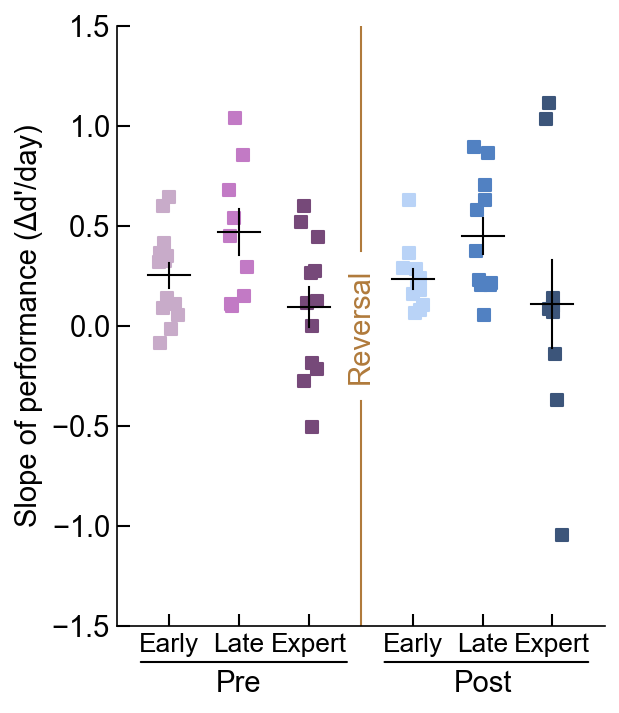

In [15]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [dpslope_pre_early,dpslope_pre_late,dpslope_pre_expert,dpslope_post_early,dpslope_post_late,dpslope_post_expert]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-1.5,1.5])
ax.set_yticks([-1.5,-1.0,-0.5,0,0.5,1,1.5])
ylab = ax.set_ylabel('Slope of performance (Δd\'/day)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
#fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Slope of learning over phases V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(artists), bbox_inches='tight')

In [25]:
print(normaltest(ilep.rmnan(dpslope_pre_early)))
print(normaltest(ilep.rmnan(dpslope_pre_late)))
print(normaltest(ilep.rmnan(dpslope_pre_expert)))
print(normaltest(ilep.rmnan(dpslope_post_early)))
print(normaltest(ilep.rmnan(dpslope_post_late)))
print(normaltest(ilep.rmnan(dpslope_post_expert)))

NormaltestResult(statistic=0.6075971746571973, pvalue=0.7380094959462549)
NormaltestResult(statistic=2.2069659654654896, pvalue=0.331713716176893)
NormaltestResult(statistic=0.7346447203618951, pvalue=0.6925863467950187)
NormaltestResult(statistic=10.316071420493216, pvalue=0.005752989131755469)
NormaltestResult(statistic=3.3585884345504855, pvalue=0.1865055620021303)
NormaltestResult(statistic=1.1092491284956285, pvalue=0.5742878289110087)


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\scipy\stats\_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [26]:
print(f"pre early: {np.nanmean(dpslope_pre_early)} +/- {np.std(ilep.rmnan(dpslope_pre_early))}")
print(f"pre late: {np.nanmean(dpslope_pre_late)} +/- {np.std(ilep.rmnan(dpslope_pre_late))}")
print(f"pre expert: {np.nanmean(dpslope_pre_expert)} +/- {np.std(ilep.rmnan(dpslope_pre_expert))}")
print(f"post early: {np.nanmean(dpslope_post_early)} +/- {np.std(ilep.rmnan(dpslope_post_early))}")
print(f"post late: {np.nanmean(dpslope_post_late)} +/- {np.std(ilep.rmnan(dpslope_post_late))}")
print(f"post expert: {np.nanmean(dpslope_post_expert)} +/- {np.std(ilep.rmnan(dpslope_post_expert))}")

pre early: 0.24919351885452717 +/- 0.20902508309181683
pre late: 0.5374341734806145 +/- 0.4062781377892222
pre expert: 0.06089793454425575 +/- 0.3179756971994879
post early: 0.21021360252749421 +/- 0.15255628658294815
post late: 0.5429793703852652 +/- 0.33702191135526954
post expert: 0.11365037840882347 +/- 0.5629850875902761


In [30]:
print(np.sum(np.isfinite(dpslope_pre_early)))
print(np.sum(np.isfinite(dpslope_pre_late)))
print(np.sum(np.isfinite(dpslope_pre_expert)))
print(np.sum(np.isfinite(dpslope_post_early)))
print(np.sum(np.isfinite(dpslope_post_late)))
print(np.sum(np.isfinite(dpslope_post_expert)))

15
11
14
13
13
11


In [34]:
# Not all animals have every phase for pre and post. For this reason it's best to run an unpaired parametric test since
# We want to use all of the data

A1 = ilep.rmnan(dpslope_pre_early)
B1 = ilep.rmnan(dpslope_pre_late)
C1 = ilep.rmnan(dpslope_pre_expert)

A2 = ilep.rmnan(dpslope_post_early)
B2 = ilep.rmnan(dpslope_post_late)
C2 = ilep.rmnan(dpslope_post_expert)

ps = []

X,Y = (A1,B1)
ps.append(ttest_ind(X,Y).pvalue)
X,Y = (B1,C1)
ps.append(ttest_ind(X,Y).pvalue)

X,Y = (A2,B2)
ps.append(ttest_ind(X,Y).pvalue)
X,Y = (B2,C2)
ps.append(ttest_ind(X,Y).pvalue)

# print(ps)
_,ps = pg.multicomp(ps,method='fdr_bh')
print(ps)

[0.03809488 0.00940694 0.00940694 0.03809488]


In [75]:
Data = SimpleNamespace()
Data.preearly = dpslope_pre_early
Data.prelate = dpslope_pre_late
Data.preexpert = dpslope_pre_expert
Data.postearly = dpslope_post_early
Data.postlate = dpslope_post_late
Data.postexpert = dpslope_post_expert
ilep.nonparametricIndependentStatsCompareToPrevious(Data)

            Source         SS    DF        MS         F     p-unc       np2
0            phase   0.160716   3.0  0.053572  0.400355  0.753063  0.012750
1          context   0.090291   1.0  0.090291  0.674759  0.413498  0.007203
2  phase * context   3.653845   3.0  1.217948  9.101976  0.000024  0.226971
3         Residual  12.444461  93.0  0.133811       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.017530  0.023373  0.872744
8     post-late  baseline  experimental  0.011977  0.023373 -1.183595
9    pre-expert  baseline  experimental  0.009312  0.023373  1.229473
10     pre-late  baseline  experimental  0.077631  0.077631 -0.869929
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 14 non-nan elements
key postearly has 13 non-nan elements
key postlate has 13 non-nan elements
key postexpert has 11 non-nan elements


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,299.5,two-sided,0.815689,1.000000,fdr_bh,-0.070839
1,phase,-,post-expert,pre-expert,False,False,334.0,two-sided,0.502858,1.000000,fdr_bh,0.156027
2,phase,-,post-expert,pre-late,False,False,307.0,two-sided,0.930367,1.000000,fdr_bh,-0.056500
3,phase,-,post-late,pre-expert,False,False,378.0,two-sided,0.322557,1.000000,fdr_bh,0.273684
4,phase,-,post-late,pre-late,False,False,338.0,two-sided,1.000000,1.000000,fdr_bh,0.016204
5,phase,-,pre-expert,pre-late,False,False,273.5,two-sided,0.336455,1.000000,fdr_bh,-0.250961
6,context,-,baseline,experimental,False,False,1396.0,two-sided,0.409001,NaN,NaN,0.162240
7,phase * context,post-expert,baseline,experimental,False,False,113.0,two-sided,0.017530,0.023373,fdr_bh,0.872744
8,phase * context,post-late,baseline,experimental,False,False,35.0,two-sided,0.011977,0.023373,fdr_bh,-1.183595
9,phase * context,pre-expert,baseline,experimental,False,False,125.0,two-sided,0.009312,0.023373,fdr_bh,1.229473


In [77]:
dpslope_pre_early

[0.08768889567344107,
 -0.08552988211994061,
 0.41655200835981504,
 0.05278044452810611,
 0.11123556677021339,
 -0.016548892037022464,
 0.32312378969435657,
 0.6425287627163723,
 0.13881719983133645,
 0.3498228917222954,
 0.3180262649010278,
 0.6015277106956368,
 0.36455486429191464,
 0.085855097272959,
 0.34746806051739604]